<a href="https://colab.research.google.com/github/ccg-esb-lab/ARCfitness/blob/main/MonodGillespieARC_3_stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Model of ARC Stability

This notebook presents the stochastic resource-explicit model describing the competitive dynamics between the reference strain and ARC-bearing populations.  
The implementation follows a discrete-time τ-leaping (Gillespie-like) approach, where growth and resource depletion are coupled through Monod kinetics.  
Population updates, dilution steps, and extinction thresholds are explicitly defined to reproduce serial-transfer dynamics under constant or fluctuating oxygen regimes.


In [1]:
import os
import re
import time
import copy
import pickle
from dataclasses import dataclass

from pathlib import Path, Path as P
from pathlib import Path
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch, Ellipse
from matplotlib.ticker import MultipleLocator
from numpy.linalg import lstsq


import matplotlib.image as mpimg


plt.rcParams.update({
    "axes.labelsize": 16,   # fontsize for axis labels
    "xtick.labelsize": 14,  # fontsize for x-axis tick labels
    "ytick.labelsize": 14   # fontsize for y-axis tick labels
})

## Set experimental parameters

Model parameters:

In [2]:
initial_resource = 1.0
simulation_time = 24.0
B0=1e6
od2cells = 1e9

#ref_family=''
#ref_key='pMBA'

families=['all','dfr', 'bla', 'aa', 'mix'] #

p0={'Vmax': np.float64(0.9454613328338227), 'K': np.float64(1.9990081879151718), 'c': np.float64(1.0699679059334099e-09)}

Simulation parameters:

In [3]:
#labels_of_interest = ["ereA2", "aacA7", "OXA10", "dfrA31","qacE","OXA1","OXA118","fosF", "BEL1", "GES1", "IMP2", "IMP31", "OXA129","OXA196", "VIM2", "VIM7", "dfrA6", "dfrB2", "aphA16", "aadB", "fosC2", "fosE", "fosG", "fosH", "fosI", "fosK", "fosL", "fosM", "fosN"]
#families=['dfr', 'bla', 'aa', 'mix']

#n_syn=1000


#exportData=True
#simulateData=True


In [4]:
#family = 'all'

labels_of_interest = ["ereA2", "aacA7", "OXA10", "dfrA31","qacE"]

#num_days = 14
#K=7 # Day when switch to aerobiosis is performed
#sched_name = 'Switch_K%s'%K

sched_name = 'sim'
#schedule = MG.make_switch_schedule(first_env="G", switch_day=K, num_days=num_days, second_env="E")

E_color = "#B63E36"   # aerobiosis (anaerobiosis)
G_color = "#EBDD99"   # anaerobiosis (aerobiosis)

#Ks_to_show = [25, 50, 75]

___

## Clone GitHub Repo

In [5]:


REPO=False


if REPO:
    repo_url = "https://github.com/ccg-esb-lab/ARCfitness.git"
    repo_name = "ARCfitness"
    
    if not Path(repo_name).exists():
        !git clone {repo_url}
    
    REPO_ROOT = Path(repo_name).resolve()
    print("Repo root:", REPO_ROOT)
    
    # Create local folders for figures and processed simulations.
    pathCODE = REPO_ROOT / "code"
    pathFIGURES = REPO_ROOT / "figures"
    pathSIM = REPO_ROOT / "sim"
    
    pathFIGURES.mkdir(parents=True, exist_ok=True)
    pathSIM.mkdir(parents=True, exist_ok=True)



In [6]:
if not REPO:
    REPO_ROOT = Path("./").expanduser().resolve()
    
    if not REPO_ROOT.exists():
        raise FileNotFoundError(f"Repo not found at {REPO_ROOT}")
    
    print("Repo root:", REPO_ROOT)
    
    pathCODE    = REPO_ROOT / "code"
    pathFIGURES = REPO_ROOT / "figures"
    pathDATA    = REPO_ROOT / "data"
    
    # Create output dirs if missing
    pathFIGURES.mkdir(parents=True, exist_ok=True)
    
    print("pathCODE:", pathCODE)
    print("pathDATA:", pathDATA)
    print("pathFIGURES:", pathFIGURES)


Repo root: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main
pathCODE: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/code
pathDATA: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/data
pathFIGURES: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/figures


In [7]:
import sys, importlib, importlib.util

print("pathCODE =", pathCODE)
print("as str   =", str(pathCODE))

# Put code folder first (highest priority)
p = str(pathCODE)
if p in sys.path:
    sys.path.remove(p)
sys.path.insert(0, p)

# Force a clean import
sys.modules.pop("MonodGillespieMI", None)
sys.modules.pop("MonodGillespieMI_IO", None)

import MonodGillespieMI as MG
import MonodGillespieMI_IO as IO

print("\nLoaded MonodGillespieMI from:", MG.__file__)
print("Loaded MonodGillespieMI_IO from:", IO.__file__)


pathCODE = /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/code
as str   = /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/code

Loaded MonodGillespieMI from: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/code/MonodGillespieMI.py
Loaded MonodGillespieMI_IO from: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/code/MonodGillespieMI_IO.py


___

In [8]:

def _ellipse_axis_aligned(ax, x, y, nsig_levels=(1,2), color='black', alpha=0.8, lw=1.5):
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 2:  # need at least 2 points for std
        return
    mu_x, mu_y = np.nanmean(x), np.nanmean(y)
    sx = np.nanstd(x, ddof=1) if x.size >= 2 else 0.0
    sy = np.nanstd(y, ddof=1) if y.size >= 2 else 0.0
    if not (np.isfinite(sx) and np.isfinite(sy)) or (sx == 0 and sy == 0):
        return
    for nsig in nsig_levels:
        w = 2 * nsig * sx
        h = 2 * nsig * sy
        if w > 0 and h > 0:
            ax.add_patch(Ellipse((mu_x, mu_y), width=w, height=h, angle=0.0,
                                 edgecolor=color, facecolor='none', lw=lw, alpha=alpha, zorder=3))

def _ellipse_rotated(ax, x, y, nsig_levels=(1,2), color='black', alpha=0.8, lw=1.5):
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 3:  # covariance needs ≥3 for stable ddof=1
        return
    mu_x, mu_y = np.nanmean(x), np.nanmean(y)
    cov = np.cov(np.vstack([x, y]), ddof=1)
    if not np.all(np.isfinite(cov)):
        return
    vals, vecs = np.linalg.eigh(cov)          # ascending eigenvalues
    vals = np.clip(vals, 0.0, None)           # numeric safety
    angle_deg = np.degrees(np.arctan2(vecs[1,1], vecs[0,1]))  # major axis angle
    for nsig in nsig_levels:
        w = 2 * nsig * np.sqrt(vals[1])       # major axis
        h = 2 * nsig * np.sqrt(vals[0])       # minor axis
        if np.isfinite(w) and np.isfinite(h) and w > 0 and h > 0:
            ax.add_patch(Ellipse((mu_x, mu_y), width=w, height=h, angle=angle_deg,
                                 edgecolor=color, facecolor='none', lw=lw, alpha=alpha, zorder=3))


def plot_w_scatter(
    df_env,
    family=None,
    highlight=None,
    annotate=None,
    *,
    ellipse_mode='rotated',      # 'axis' | 'rotated' | 'auto'
    corr_threshold=0.2,          # only for ellipse_mode='auto'
    nsig_levels=(1,2),
    ellipse_color='#666666',
    ellipse_alpha=0.8,
    ellipse_lw=1.5,
    family_colors=None,          # dict like {'bla':'#1f77b4', ...}; used if family=None
    pathFIGURES='',
    ax=None
):
    """
    Scatter of relative fitness (w) in anaerobiosis (G, x-axis) vs aerobiosis (E, y-axis),
    per label, with covariance ellipses.

    df_env must have columns:
        ['label','Environment','achieved_w','family'].

    If `family` is not None:
        - Subset df_env to that family and plot it as a single cloud.
        - Draw a single ellipse on that cloud.

    If `family` is None:
        - Assume df_env may contain multiple families.
        - Plot each family in a different color.
        - Draw one ellipse per family (using that family's color).
        - Title is generic and we include a legend.

    highlight : list-like of labels to highlight (drawn on top, yellow)
    annotate  : list-like of labels to annotate with text

    Returns:
        A dict mapping family_name -> pivot_dataframe, where each pivot_dataframe
        has columns ['label','G','E','family'].
        In single-family mode, it's a dict with one key.
    """

    # defaults
    highlight = set(highlight or [])
    annotate  = set(annotate or [])

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
        created_fig = True

    def _pivot_one_family(df_sub, fam_name):
        """
        df_sub: rows of a SINGLE family
        returns pivot with columns ['label','G','E','family'] if possible
        """
        pivot = (
            df_sub.pivot_table(
                index="label",
                columns="Environment",
                values="achieved_w",
                aggfunc="mean"
            )
            .reset_index()
        )

        # Check that both environments we want are present
        missing_envs = [env for env in ['G', 'E'] if env not in pivot.columns]
        if missing_envs:
            # No paired G/E values for this family → nothing to plot
            return pd.DataFrame(columns=["label", "G", "E", "family"])

        # Drop rows that do not have BOTH E and G
        pivot = pivot.dropna(subset=['G', 'E'], how='any')

        if pivot.empty:
            return pd.DataFrame(columns=["label", "G", "E", "family"])

        pivot['family'] = fam_name
        return pivot[['label', 'G', 'E', 'family']]


    # branch 1: single family mode
    if family is not None:
        df_use = df_env[df_env['family'] == family].copy()
        if df_use.empty:
            raise ValueError(f"No rows found for family '{family}'.")

        pivot = _pivot_one_family(df_use, family)
        if pivot.empty:
            raise ValueError(f"Family '{family}' has no paired E/G fitness values.")

        # base scatter for this family
        x = pivot['G'].astype(float).to_numpy()
        y = pivot['E'].astype(float).to_numpy()
        ax.scatter(x, y, color='grey', alpha=0.2, s=20)

        # highlight subset (true experimental strains or strains of interest)
        if highlight:
            df_hl = pivot[pivot['label'].isin(highlight)]
            ax.scatter(df_hl['G'], df_hl['E'], color='yellow', alpha=0.7, s=20)

        # annotate subset
        if annotate:
            df_ann = pivot[pivot['label'].isin(annotate)]
            ax.scatter(df_ann['G'], df_ann['E'], color='red', alpha=0.8)
            for _, row in df_ann.iterrows():
                ax.text(
                    float(row['G']) + 0.01,
                    float(row['E']),
                    row['label'],
                    fontsize=9,
                    ha='left',
                    va='center',
                    color='red'
                )

        # choose ellipse mode
        _draw_ellipse_for_points(
            ax, x, y,
            ellipse_mode=ellipse_mode,
            corr_threshold=corr_threshold,
            nsig_levels=nsig_levels,
            ellipse_color=ellipse_color,
            ellipse_alpha=ellipse_alpha,
            ellipse_lw=ellipse_lw
        )

        # axis formatting
        ax.set_xlim(0.5, 1.5)
        ax.set_ylim(0.5, 1.5)
        ax.set_aspect('equal', adjustable='box')
        ax.axhline(1, color='black', linestyle='--', alpha=0.7)
        ax.axvline(1, color='black', linestyle='--', alpha=0.7)
        ax.set_xlabel("Relative fitness (anaerobiosis)")
        ax.set_ylabel("Relative fitness (aerobiosis)")
        ax.set_title(family.upper())

        # save/show if standalone
        if created_fig:
            plt.tight_layout()
            if pathFIGURES:
                filename = f"{pathFIGURES}/w_scatter_{family}.pdf"
                plt.savefig(filename, format='pdf', bbox_inches='tight')
                print(f"Exporting {filename}")
            plt.show()

        return {family: pivot}

    # branch 2: multi-family overlay mode
    # -----------------------------------
    fam_results = {}
    fam_list = sorted(df_env['family'].dropna().unique().tolist())
    if family_colors is None:
        # fallback palette
        default_cols = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b']
        family_colors = {f: default_cols[i % len(default_cols)] for i, f in enumerate(fam_list)}

    for fam_name in fam_list:
        df_sub = df_env[df_env['family'] == fam_name].copy()
        if df_sub.empty:
            continue

        pivot_f = _pivot_one_family(df_sub, fam_name)
        if pivot_f.empty:
            continue

        fam_results[fam_name] = pivot_f

        x = pivot_f['G'].astype(float).to_numpy()
        y = pivot_f['E'].astype(float).to_numpy()
        col = family_colors.get(fam_name, 'gray')

        # scatter for this family
        ax.scatter(
            x, y,
            s=20,
            alpha=0.4,
            color=col
        )

        # annotate/highlight logic could optionally be family-specific;
        # here we apply globally:
        if highlight:
            df_hl = pivot_f[pivot_f['label'].isin(highlight)]
            if not df_hl.empty:
                ax.scatter(df_hl['G'], df_hl['E'], color='yellow', alpha=0.7, s=20)
        if annotate:
            df_ann = pivot_f[pivot_f['label'].isin(annotate)]
            if not df_ann.empty:
                ax.scatter(df_ann['G'], df_ann['E'], color='red', alpha=0.8)
                for _, row in df_ann.iterrows():
                    ax.text(
                        float(row['G']) + 0.01,
                        float(row['E']),
                        row['label'],
                        fontsize=9,
                        ha='left',
                        va='center',
                        color='red'
                    )

        # ellipse for this family, in that family's color but transparent
        _draw_ellipse_for_points(
            ax, x, y,
            ellipse_mode=ellipse_mode,
            corr_threshold=corr_threshold,
            nsig_levels=nsig_levels,
            ellipse_color=col,
            ellipse_alpha=0.15,        # lighter fill for multi-family
            ellipse_lw=1.5
        )

    # common axis formatting for overlay
    ax.set_xlim(0.5, 1.5)
    ax.set_ylim(0.5, 1.5)
    ax.set_aspect('equal', adjustable='box')
    ax.axhline(1, color='black', linestyle='--', alpha=0.7)
    ax.axvline(1, color='black', linestyle='--', alpha=0.7)
    ax.set_xlabel("Relative fitness (anaerobiosis)")
    ax.set_ylabel("Relative fitness (aerobiosis)")
    ax.set_title("")
    ax.legend(frameon=False)

    if created_fig:
        plt.tight_layout()
        if pathFIGURES:
            filename = f"{pathFIGURES}/w_scatter_allfamilies.pdf"
            plt.savefig(filename, format='pdf', bbox_inches='tight', dpi=300)
            print(f"Exporting {filename}")
        plt.show()

    return fam_results


def _draw_ellipse_for_points(
    ax, x, y,
    *,
    ellipse_mode,
    corr_threshold,
    nsig_levels,
    ellipse_color,
    ellipse_alpha,
    ellipse_lw
):
    """
    Chooses axis-aligned vs rotated ellipse based on mode and corr.
    Calls your existing _ellipse_axis_aligned / _ellipse_rotated.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    mode = ellipse_mode.lower()
    if mode == 'axis':
        _ellipse_axis_aligned(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)
        return

    if mode == 'rotated':
        _ellipse_rotated(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)
        return

    # auto mode
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() >= 2:
        corr = np.corrcoef(x[mask], y[mask])[0,1]
    else:
        corr = np.nan

    if np.isfinite(corr) and abs(corr) >= float(corr_threshold):
        _ellipse_rotated(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)
    else:
        _ellipse_axis_aligned(ax, x, y, nsig_levels, ellipse_color, ellipse_alpha, ellipse_lw)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


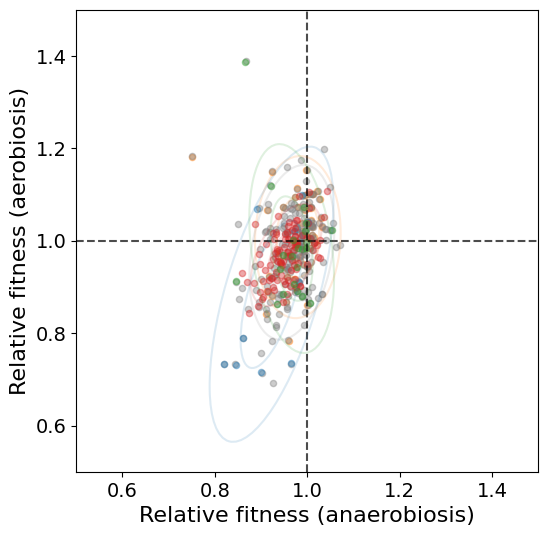

In [9]:
df_concat = []

for fam in families:
    csv_path = REPO_ROOT / "data" / f"fitness_{fam}.csv"
    df_family = (
        pd.read_csv(csv_path)
        .dropna(how="all")
        .dropna(axis=1, how="all")
    )
    df_concat.append(df_family)

df_all = pd.concat(df_concat, ignore_index=True)

fig, ax = plt.subplots(figsize=(6, 6))
out_multi = plot_w_scatter(
    df_all,
    family=None,
    highlight=[],
    annotate=[],
    ellipse_mode="rotated",
    family_colors={
        "bla": "#1f77b4",
        "aa": "#ff7f0e",
        "mix": "#2ca02c",
        "dfr": "#d62728",
    },
    pathFIGURES=pathFIGURES,
    ax=ax,
)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def _pivot_one_family(df_sub, fam_name):
    """
    df_sub: rows of a SINGLE family
    returns pivot with columns ['label','G','E','family'] if possible
    """
    pivot = (
        df_sub.pivot_table(
            index="label",
            columns="Environment",
            values="achieved_w",
            aggfunc="mean"
        )
        .reset_index()
    )

    # Check that both environments we want are present
    missing_envs = [env for env in ['G', 'E'] if env not in pivot.columns]
    if missing_envs:
        # No paired G/E values for this family → nothing to plot
        return pd.DataFrame(columns=["label", "G", "E", "family"])

    # Drop rows that do not have BOTH E and G
    pivot = pivot.dropna(subset=['G', 'E'], how='any')

    if pivot.empty:
        return pd.DataFrame(columns=["label", "G", "E", "family"])

    pivot['family'] = fam_name
    return pivot[['label', 'G', 'E', 'family']]



def _draw_ellipse_for_points(
    ax, x, y,
    *,
    ellipse_mode='rotated',
    corr_threshold=0.2,
    nsig_levels=(1,2),
    ellipse_color='#666666',
    ellipse_alpha=0.15,
    ellipse_lw=1.5
):
    """
    Decide axis-aligned vs rotated ellipse for a single set of points (x,y)
    and draw it on ax.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    mode = ellipse_mode.lower()
    if mode == 'axis':
        _ellipse_axis_aligned(ax, x, y, nsig_levels,
                              ellipse_color, ellipse_alpha, ellipse_lw)
        return

    if mode == 'rotated':
        _ellipse_rotated(ax, x, y, nsig_levels,
                         ellipse_color, ellipse_alpha, ellipse_lw)
        return

    # auto mode
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() >= 2:
        corr = np.corrcoef(x[mask], y[mask])[0,1]
    else:
        corr = np.nan

    if np.isfinite(corr) and abs(corr) >= float(corr_threshold):
        _ellipse_rotated(ax, x, y, nsig_levels,
                         ellipse_color, ellipse_alpha, ellipse_lw)
    else:
        _ellipse_axis_aligned(ax, x, y, nsig_levels,
                              ellipse_color, ellipse_alpha, ellipse_lw)


def plot_joint_with_marginals(
    df_env_all,
    families=('bla','aa','mix','dfr'),
    family_colors=None,
    highlight=None,
    annotate=None,
    *,
    ellipse_mode='rotated',
    corr_threshold=0.2,
    nsig_levels=(1,2),
    bins=20,
    xlim=(0.5, 1.5),
    ylim=(0.5, 1.5),
    pathFIGURES='',
    filename='w_joint_marginals.pdf'
):
    """
    Make a joint distribution plot:
    - center: G vs E scatter with ellipses, colored by family
    - top: histogram of E (aerobic fitness)
    - right: histogram of G (anaerobic fitness)

    df_env_all must contain rows from multiple families, columns:
        ['family','label','Environment','achieved_w']

    highlight : list of labels to highlight in yellow in the scatter
    annotate  : list of labels to annotate in red in the scatter
    """

    if highlight is None:
        highlight = []
    if annotate is None:
        annotate = []

    # default color palette if not provided
    if family_colors is None:
        default_cols = ['#1f77b4','#ff7f0e','#2ca02c','#d62728',
                        '#9467bd','#8c564b']
        family_colors = {
            fam: default_cols[i % len(default_cols)]
            for i, fam in enumerate(families)
        }

    # pivot each family separately to get paired E/G
    fam_pivots = {}
    for fam in families:
        df_sub = df_env_all[df_env_all['family'] == fam].copy()
        if df_sub.empty:
            continue
        pvt = _pivot_one_family(df_sub, fam)
        if not pvt.empty:
            fam_pivots[fam] = pvt

    # --- build figure layout manually with GridSpec ---
    fig = plt.figure(figsize=(8,8))

    # GridSpec: 2 rows x 2 cols
    # top row: [top hist  | empty ]
    # bottom : [scatter   | right hist]
    gs = GridSpec(
        2, 2,
        width_ratios=[4,1],
        height_ratios=[1,4],
        wspace=0.05,
        hspace=0.05,
        figure=fig
    )

    ax_top     = fig.add_subplot(gs[0,0])  # top histogram
    ax_scatter = fig.add_subplot(gs[1,0])  # joint scatter
    ax_right   = fig.add_subplot(gs[1,1])  # right histogram

    # We'll hide ax_top's x tick labels except maybe max,
    # and hide ax_right's y tick labels.

    # -------- center scatter --------
    legend_handles = []
    for fam in families:
        if fam not in fam_pivots:
            continue
        pvt = fam_pivots[fam]
        col = family_colors.get(fam, 'gray')

        xvals = pvt['G'].astype(float).to_numpy()  # anaerobic
        yvals = pvt['E'].astype(float).to_numpy()  # aerobic

        pts = ax_scatter.scatter(
            xvals, yvals,
            s=20, alpha=0.1,
            color=col,
            label=fam.upper()
        )
        legend_handles.append(pts)

        # highlight
        if len(highlight) > 0:
            hl = pvt[pvt['label'].isin(highlight)]
            if not hl.empty:
                ax_scatter.scatter(
                    hl['G'], hl['E'],
                    s=20, alpha=0.7,
                    color='yellow',
                    edgecolor='k', linewidth=0.5
                )

        # annotate
        if len(annotate) > 0:
            ann = pvt[pvt['label'].isin(annotate)]
            if not ann.empty:
                ax_scatter.scatter(
                    ann['G'], ann['E'],
                    s=20, alpha=0.8,
                    color='red'
                )
                for _, row in ann.iterrows():
                    ax_scatter.text(
                        float(row['G']) + 0.01,
                        float(row['E']),
                        row['label'],
                        fontsize=8,
                        ha='left', va='center',
                        color='red'
                    )

        # ellipse for this family
        _draw_ellipse_for_points(
            ax_scatter,
            xvals, yvals,
            ellipse_mode=ellipse_mode,
            corr_threshold=corr_threshold,
            nsig_levels=nsig_levels,
            ellipse_color=col,
            ellipse_alpha=0.5,
            ellipse_lw=1.5
        )

        # -------- marginals: top hist (E), right hist (G) --------
        ax_top.hist(
            yvals,
            bins=bins,
            range=ylim,
            color=col,
            alpha=0.4,
            histtype='stepfilled',
            linewidth=1.0
        )
        ax_right.hist(
            xvals,
            bins=bins,
            range=xlim,
            color=col,
            alpha=0.4,
            histtype='stepfilled',
            linewidth=1.0,
            orientation='horizontal'
        )

    # decorate scatter
    ax_scatter.set_xlim(*xlim)
    ax_scatter.set_ylim(*ylim)
    ax_scatter.set_aspect('equal', adjustable='box')
    ax_scatter.axhline(1, color='black', linestyle='--', alpha=0.7)
    ax_scatter.axvline(1, color='black', linestyle='--', alpha=0.7)
    ax_scatter.set_xlabel("Relative fitness (anaerobiosis)")
    ax_scatter.set_ylabel("Relative fitness (aerobiosis)")

    # add legend (families)
    if legend_handles:
        ax_scatter.legend(frameon=False, loc='lower right')

    # decorate top histogram (E marginal)
    ax_top.set_xlim(*ylim)  # note: yvals were aerobic fitness; plotted along x here
    ax_top.set_xticks([])
    ax_top.set_yticks([])
    ax_top.set_ylabel("Count", fontsize=9)
    # remove spines except bottom
    for spine in ['top','right','left']:
        ax_top.spines[spine].set_visible(False)

    # decorate right histogram (G marginal)
    ax_right.set_ylim(*xlim)  # note: xvals were anaerobic fitness; plotted along y here
    ax_right.set_xticks([])
    ax_right.set_yticks([])
    ax_right.set_xlabel("Count", fontsize=9)
    # remove spines except left
    for spine in ['top','right','bottom']:
        ax_right.spines[spine].set_visible(False)

    # clean shared borders between panels
    ax_top.spines['bottom'].set_visible(True)
    ax_right.spines['left'].set_visible(True)

    # layout and save
    plt.tight_layout()
    if pathFIGURES:
        outpath = f"{pathFIGURES}/{filename}"
        plt.savefig(outpath, dpi=300, bbox_inches='tight')
        print(f"Exporting {outpath}")
    plt.show()

    return fam_pivots


/var/folders/h1/g_1_5rzj18v0475wpb5gyc8r0000gn/T/ipykernel_86090/3993776360.py:273: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Exporting /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/figures/w_joint_marginals_2sigma.png


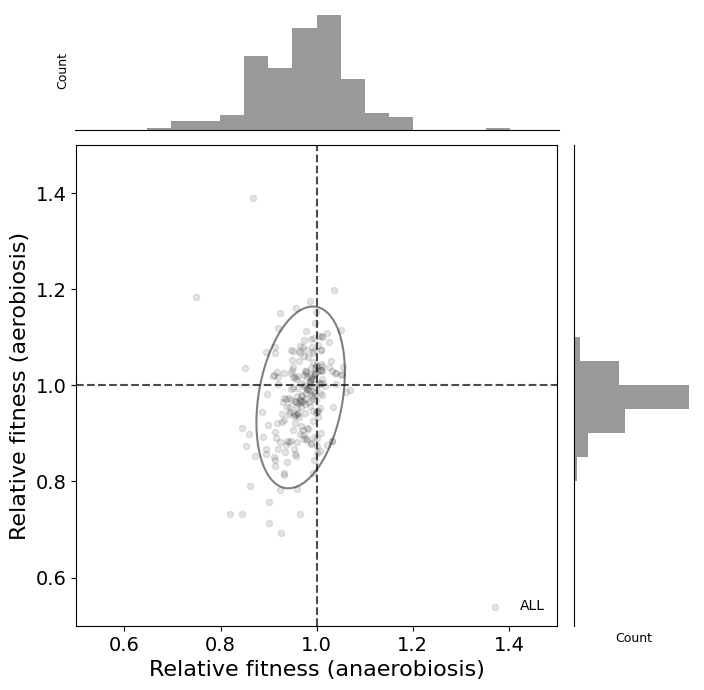

{'all': Environment   label         G         E family
 0              BEL1  0.989690  1.078923    all
 1              GES1  0.972736  1.020450    all
 2              IMP2  0.932827  0.928849    all
 3             IMP31  0.819692  0.733286    all
 4              OXA1  0.894508  1.069838    all
 ..              ...       ...       ...    ...
 216          x_0216  0.991873  0.926070    all
 217          x_0217  0.912718  0.902965    all
 218          x_0218  0.971864  0.968237    all
 219          x_0219  0.920297  1.003690    all
 220          x_0220  0.886020  0.945110    all
 
 [221 rows x 4 columns]}

In [11]:


plot_joint_with_marginals(
    df_env_all=df_all,
    families=['all'],
    family_colors={
        'bla':'#1f77b4',
        'aa':'#ff7f0e',
        'mix':'#2ca02c',
        'dfr':'#d62728',
        'all':'#000000'
    },
    nsig_levels=(2,),        # <-- only 2σ contours
    ellipse_mode='rotated',
    corr_threshold=0.2,
    bins=20,
    xlim=(0.5,1.5),
    ylim=(0.5,1.5),
    pathFIGURES=pathFIGURES,
    filename='w_joint_marginals_2sigma.pdf'
)



In [12]:

def params_from_row(row):
    return {
        'Vmax': float(row['Vmax']),
        'K':          float(row['K']),
        'c':          float(row['c'])
    }

def _run_one_day(sim_fn, pA, pB, NA_init, NB_init, initial_resource, hours):
    strains = [
        {'Vmax': pA['Vmax'], 'death_rate': 0.0, 'initial_population': NA_init,
         'K': pA['K'], 'c': pA['c'], 'A_half': 0.5},
        {'Vmax': pB['Vmax'], 'death_rate': 0.0, 'initial_population': NB_init,
         'K': pB['K'], 'c': pB['c'], 'A_half': 0.5},
    ]
    out = sim_fn(
        strains=strains,
        initial_resource=initial_resource,
        simulation_time=hours
    )
    if len(out) == 2:
        t, pops = out; res = None
    else:
        t, pops, res = out
    return np.asarray(t, float), np.asarray(pops, float), res

def serial_transfer_competition(
    env_schedule,
    row_G, row_E,
    p0,
    sim_fn, initial_resource,
    day_hours=24.0,
    dilution=100.0,
    Ntot0_start=2e8,
    freqA0_start=0.5,
    p0_G=None, p0_E=None,
    N_extinct=1.0,                 # <- NEW: extinction threshold (cells)
    stochastic_bottleneck=False,   # <- NEW: Poisson bottleneck at dilution
    rng=None
):
    import numpy as np
    import pandas as pd
    rng = np.random.default_rng(rng)

    Na0 = float(Ntot0_start * freqA0_start)
    Nb0 = float(Ntot0_start - Na0)

    all_t, all_pops, segments, day_rows = [], [], [], []
    t_offset = 0.0

    for day_idx, env in enumerate(env_schedule, start=1):
        env = str(env).upper().strip()
        if env not in {'G','E'}:
            raise ValueError(f"Environment must be 'G' or 'E', got {env}")

        pA = params_from_row(row_G) if env == 'G' else params_from_row(row_E)
        pB = (p0_G if (env == 'G' and p0_G is not None)
              else p0_E if (env == 'E' and p0_E is not None)
              else p0)

        # Simulate one day
        t_day, pops_day, _ = _run_one_day(sim_fn, pA, pB, Na0, Nb0, initial_resource, day_hours)

        # Store absolute-time segment
        t_abs = t_day + t_offset
        all_t.append(t_abs)
        all_pops.append(pops_day)
        segments.append((t_abs, pops_day))
        t_offset += day_hours

        # End-of-day sizes
        Na_end, Nb_end = float(pops_day[-1, 0]), float(pops_day[-1, 1])

        # --- Extinction rule (apply BEFORE dilution) ---
        extinctA = Na_end < N_extinct
        extinctB = Nb_end < N_extinct
        if extinctA: Na_end = 0.0
        if extinctB: Nb_end = 0.0

        # Compute starts/ends and frequencies for summaries
        Na_start, Nb_start = float(Na0), float(Nb0)
        Ntot_start = max(Na_start + Nb_start, 1e-12)
        Ntot_end   = max(Na_end   + Nb_end,   1e-12)
        fA_start, fB_start = Na_start / Ntot_start, Nb_start / Ntot_start
        fA_end,   fB_end   = (0.0 if Na_end==0 else Na_end/Ntot_end,
                              0.0 if Nb_end==0 else Nb_end/Ntot_end)


        day_rows.append({
            'day': day_idx, 'env': env,
            'Na_start': Na_start, 'Nb_start': Nb_start,
            'Na_end': Na_end,     'Nb_end': Nb_end,
            'fA_start': fA_start, 'fB_start': fB_start,
            'fA_end': fA_end,     'fB_end': fB_end,
            'extinctA': bool(extinctA), 'extinctB': bool(extinctB)
        })

        # --- Dilution to seed next day ---
        if stochastic_bottleneck:
            # Poisson sampling of survivors after dilution
            Na0 = rng.poisson(Na_end / float(dilution))
            Nb0 = rng.poisson(Nb_end / float(dilution))
        else:
            Na0 = Na_end / float(dilution)
            Nb0 = Nb_end / float(dilution)

        # Once extinct, keep at zero
        if Na0 < N_extinct: Na0 = 0.0
        if Nb0 < N_extinct: Nb0 = 0.0

    # Concatenate across days
    time_all = np.concatenate(all_t) if all_t else np.array([])
    pops_all = np.vstack(all_pops)   if all_pops else np.zeros((0,2))
    day_summaries = pd.DataFrame(day_rows)

    return {'time': time_all, 'pops': pops_all,
            'day_summaries': day_summaries, 'segments': segments}


In [13]:
def _draw_env_band(ax, segments, day_summaries,
                   x_factor=1.0,                    # e.g. 1/24.0 for days
                   colors={'G': '#EBDD99', 'E': '#B63E36'},
                   alpha=0.12, ypad=0.0):
    """
    Draw environment background spans per day.
    segments: list of (t_abs, env_label) with times in HOURS.
    day_summaries: DataFrame with an 'env' column.
    x_factor: multiply times by this factor for the plot axis.
    """
    import numpy as np

    ymin, ymax = ax.get_ylim()
    ymin -= ypad; ymax += ypad

    for (t_abs, _), (_, row) in zip(segments, day_summaries.iterrows()):
        if t_abs is None or len(t_abs) == 0:
            continue
        x0 = float(t_abs[0]) * x_factor
        x1 = float(t_abs[-1]) * x_factor
        env = str(row.get('env', '')).strip()
        col = colors.get(env, '#BBBBBB')
        ax.axvspan(x0, x1, ymin=0, ymax=1, facecolor=col, alpha=alpha, edgecolor='none')

    ax.set_ylim(ymin, ymax)


# === 1) Full trajectory with env band ===
def plot_trajectories_single(res, labelA="control pMBA", labelB="BX",
                                    colorA="0.25", colorB="#440154", lsA="--", lsB="-",
                                    title=None,pathFIGURES=''):
    """
    Plot continuous trajectories (Na, Nb) across all days and draw a top band
    that encodes the environment per day (E=blue, G=orange).
    """
    t = res['time']
    pops = res['pops']
    Na, Nb = pops[:,0], pops[:,1]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(t, Na, label=labelA, color=colorA, ls=lsA, lw=1)
    ax.plot(t, Nb, label=labelB, color=colorB, ls=lsB, lw=2)
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Cells/mL')
    ax.set_xlim(0, t[-1])
    ax.set_ylim(0, 1.1*max(Na.max(), Nb.max()))
    ax.xaxis.set_major_locator(MultipleLocator(24))
    if title:
        ax.set_title(title)
    ax.grid(True, alpha=0.)
    ax.legend(frameon=False, fontsize=14, loc='upper left')

    # Environment band
    _draw_env_band(ax, res['segments'], res['day_summaries'])

    plt.tight_layout()

    if pathFIGURES != '':
            filename = f"{pathFIGURES}/trajectories_{title}.pdf"
            plt.savefig(filename, format='pdf')
            print("Exporting %s" % filename)
    plt.show()
    return ax


def plot_final_frequencies_per_day_single(
    res,
    labelA=r"pMBA$_\emptyset$", labelB="ARC",
    colorA="0.25", colorB="#440154", pathFIGURES='',
    title=""
):
    """
    Plot frequencies (proportions) at the end of each day, with day 0 prepended
    from the start of day 1. Includes environment band aligned to time.
    Expects 'res' from serial_transfer_competition.
    """
    df = res['day_summaries'].copy()
    if df.empty:
        raise ValueError("day_summaries is empty in 'res'.")

    # Build plotting table with day 0 from starts of day 1
    day0 = {
        'day': 0,
        'env': df.iloc[0]['env'],
        'fA_end': df.iloc[0]['fA_start'],
        'fB_end': df.iloc[0]['fB_start']
    }
    df_plot = pd.concat([pd.DataFrame([day0]), df[['day','env','fA_end','fB_end']]], ignore_index=True)

    # X positions = absolute times: day 0 at 0; each day at its end time
    x_points = [0.0]
    for (t_abs, _), (_, _) in zip(res['segments'], res['day_summaries'].iterrows()):
        x_points.append(float(t_abs[-1]/ 24.0))

    fA = 100*df_plot['fA_end'].to_numpy(float)
    fB = 100*df_plot['fB_end'].to_numpy(float)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x_points, fA, 'o--', color=colorA, lw=1, label=labelA)
    ax.plot(x_points, fB, 'o-', color=colorB, lw=2, label=labelB)

    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Frequency (%)")
    ax.set_ylim(0, 100)
    ax.set_xlim(0, x_points[-1])
    ax.grid(True, alpha=0.)
    ax.axhline(50, color='0.5', lw=1, ls=':')
    if title:
        ax.set_title(title)
    ax.legend(frameon=False, fontsize=14, loc='lower left')

    # Top environment band
    _draw_env_band(ax, res['segments'], res['day_summaries'], x_factor=1/24.0)


    plt.tight_layout()

    if pathFIGURES != '':
            filename = f"{pathFIGURES}/final_freq_{title}.pdf"
            plt.savefig(filename, format='pdf')
            print("Exporting %s" % filename)
    plt.show()
    return ax



___

## Numerical simulations

In [14]:
this_K=30
num_days=60
this_label='ereA2'
this_family='all'
# ---------------------------------------
# LOAD fitness series from CSV
# ---------------------------------------

csv_path = REPO_ROOT / "data" / "fitness_all.csv"   # single file written by the new exporter
df_family = (
    pd.read_csv(csv_path)
    .dropna(how="all")
    .dropna(axis=1, how="all")
)

df_env = df_family[df_family["family"] == this_family].reset_index(drop=True)
print(f"[{this_family}] df_env shape:", df_env.shape)
print(df_env)

# pick rows for the focal strain
row_G = df_env[(df_env["label"] == this_label) & (df_env["Environment"] == "G")].iloc[0]
row_E = df_env[(df_env["label"] == this_label) & (df_env["Environment"] == "E")].iloc[0]


[all] df_env shape: (642, 13)
      label      Vmax        K             c  target_w  achieved_w   abs_err  \
0      VIM1  0.890209  1.99647  9.393761e-10  0.691702    0.692540  0.000838   
1      VIM1  0.931460  1.99647  1.091365e-09  0.924456    0.925863  0.001407   
2      VIM2  0.894236  1.99647  1.159401e-09  0.713427    0.713448  0.000021   
3      VIM2  0.927863  1.99647  1.090691e-09  0.901215    0.900958  0.000257   
4      OXA2  0.897801  1.99647  1.102042e-09  0.731454    0.732159  0.000705   
..      ...       ...      ...           ...       ...         ...       ...   
637  x_0218  0.938662  1.99647  1.041747e-09  0.971786    0.971864  0.000078   
638  x_0219  0.943403  1.99647  1.195633e-09  1.004688    1.003690  0.000997   
639  x_0219  0.930852  1.99647  1.270963e-09  0.920449    0.920297  0.000153   
640  x_0220  0.934667  1.99647  1.111678e-09  0.945974    0.945110  0.000864   
641  x_0220  0.925158  1.99647  1.114997e-09  0.885955    0.886020  0.000065   

         

Summary per day:
    day env      Na_start      Nb_start        Na_end        Nb_end  fA_start  \
55   56   E  7.236330e+07  2.575198e+07  7.428130e+08  2.368237e+08  0.737533   
56   57   E  7.428130e+07  2.368237e+07  7.608655e+08  2.173440e+08  0.758254   
57   58   E  7.608655e+07  2.173440e+07  7.777389e+08  1.991366e+08  0.777814   
58   59   E  7.777389e+07  1.991366e+07  7.935226e+08  1.821050e+08  0.796149   
59   60   E  7.935226e+07  1.821050e+07  8.082014e+08  1.662660e+08  0.813346   

    fB_start    fA_end    fB_end  extinctA  extinctB  
55  0.262467  0.758254  0.241746     False     False  
56  0.241746  0.777814  0.222186     False     False  
57  0.222186  0.796149  0.203851     False     False  
58  0.203851  0.813346  0.186654     False     False  
59  0.186654  0.829378  0.170622     False     False  


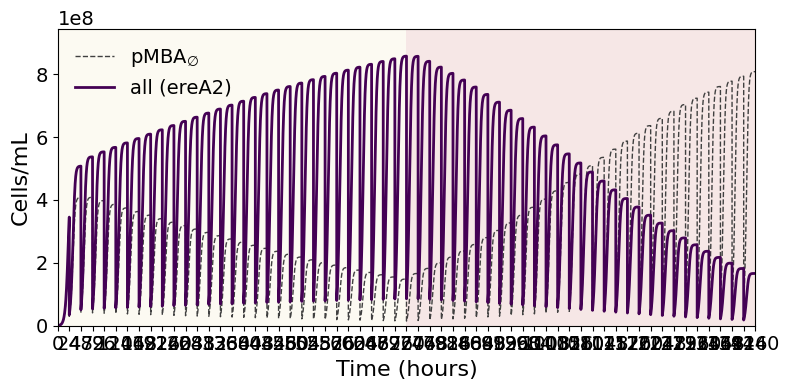

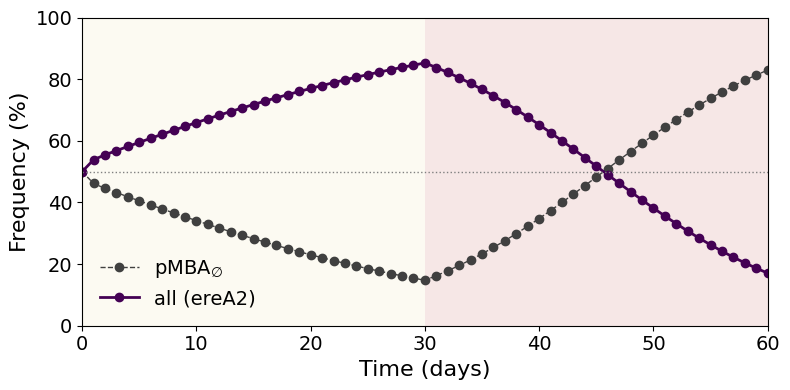

<Axes: xlabel='Time (days)', ylabel='Frequency (%)'>

In [16]:

def make_switch_schedule(first_env="G", switch_day=10, num_days=30, second_env="E"):
    if switch_day < 0 or switch_day > num_days:
        raise ValueError("switch_day must be in [0, num_days]")
    return [first_env] * switch_day + [second_env] * (num_days - switch_day)

schedule = make_switch_schedule(first_env="G", switch_day=this_K, num_days=num_days, second_env="E")
family="all"


res = serial_transfer_competition(
    env_schedule=schedule,
    row_G=row_G, row_E=row_E,
    p0=p0,
    sim_fn=MG.gillespie_bacterial_growth_batch,
    initial_resource=initial_resource,
    day_hours=24.0,
    dilution=10.0,
    Ntot0_start=1e6,
    freqA0_start=0.5
)

print("Summary per day:")
print(res['day_summaries'].tail())

# 1) Full trajectories + env band
plot_trajectories_single(
    res,
    labelA=r"pMBA$_\emptyset$",
    labelB=f"{family} ({this_label})",
    title=""
)

# 2) Daily endpoints (incl. day 0) + env band
plot_final_frequencies_per_day_single(
    res,
    labelA=r"pMBA$_\emptyset$",
    labelB=f"{family} ({this_label})",
    title=""
)


In [17]:


# --- 0) Slice day endpoints from a run ---------------------------------------
def _day_grid_and_freq(res, which='B'):
    """
    From a `serial_transfer_competition` result dict, return:
      t_days  : [0, day1_end, day2_end, ...] in DAYS
      f_series: matching frequencies for A or B at those times
    """
    # absolute end-of-day times (hours) -> to days
    x = [0.0]
    for (t_abs, _), _row in zip(res['segments'], res['day_summaries'].iterrows()):
        x.append(float(t_abs[-1]) / 24.0)
    x = np.asarray(x, float)

    df = res['day_summaries']
    fA0 = float(df.iloc[0]['fA_start'])
    fB0 = float(df.iloc[0]['fB_start'])
    fA  = np.concatenate([[fA0], df['fA_end'].to_numpy(float)])
    fB  = np.concatenate([[fB0], df['fB_end'].to_numpy(float)])

    return x, (fA if which.upper()=='A' else fB)


# --- Half-life / doubling time via log-odds slope -------------------------
@dataclass
class HalfLifeResult:
    beta_per_day: float
    t_half_days: float
    r2: float
    n_points: int

def half_life_from_run(res, which='B', eps=1e-12):
    """
    Fit log-odds vs time (days): log(f/(1-f)) = alpha + beta * t
    Returns slope beta (per day), half-life t1/2 = ln(2)/|beta|, and R^2.
    """
    t, f = _day_grid_and_freq(res, which=which)
    f = np.clip(f, eps, 1.0 - eps)
    y = np.log(f/(1.0 - f))

    # simple OLS (with intercept)
    X = np.vstack([np.ones_like(t), t]).T
    beta_hat = np.linalg.lstsq(X, y, rcond=None)[0]   # [alpha, beta]
    y_hat = X @ beta_hat

    ss_res = float(np.sum((y - y_hat)**2))
    ss_tot = float(np.sum((y - y.mean())**2))
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan

    beta = float(beta_hat[1])
    t_half = (np.log(2.0)/abs(beta)) if beta != 0 else np.inf


    print(f"β = {beta:.4f} /day, t1/2 = {t_half:.2f} days, R²={r2:.3f} (n={len(t)})")

    return HalfLifeResult(beta_per_day=beta, t_half_days=t_half, r2=r2, n_points=len(t))




In [18]:
def run_serial_transfers(
    df_env, pair_indices, schedule, p0,
    sim_fn, initial_resource,
    day_hours=24.0, dilution=100.0,
    Ntot0_start=1e6, freqA0_start=0.5,
):
    """Run serial-transfer for each pair_idx; return list of `res` dicts."""
    results = []
    for pair_idx in pair_indices:
        row_G, row_E = _get_rows_for_pair(df_env, pair_idx)
        res = serial_transfer_competition(
            env_schedule=schedule,
            row_G=row_G, row_E=row_E,
            p0=p0,
            sim_fn=sim_fn,
            initial_resource=initial_resource,
            day_hours=day_hours,
            dilution=dilution,
            Ntot0_start=Ntot0_start,
            freqA0_start=freqA0_start,
        )
        results.append(res)
    return results


def run_replicates(
    R, schedule, row_G, row_E, p0,
    sim_fn, initial_resource,
    day_hours=24.0, dilution=100.0,
    Ntot0_start=1e6, freqA0_start=0.5,
):
    """Run the same pair R times (Gillespie stochasticity); return list of `res`."""
    out = []
    for _ in range(int(R)):
        res = serial_transfer_competition(
            env_schedule=schedule,
            row_G=row_G, row_E=row_E,
            p0=p0,
            sim_fn=sim_fn,
            initial_resource=initial_resource,
            day_hours=day_hours,
            dilution=dilution,
            Ntot0_start=Ntot0_start,
            freqA0_start=freqA0_start,
        )
        out.append(res)
    return out


In [19]:


def _fit_log_odds_half_life0(day_times_h, fB_daily):
    t_days = np.asarray(day_times_h, float) / 24.0
    f = np.clip(np.asarray(fB_daily, float), 1e-9, 1-1e-9)
    y = np.log(f/(1-f))
    X = np.c_[np.ones_like(t_days), t_days]
    coef, _, _, _ = lstsq(X, y, rcond=None)
    alpha, beta = coef
    y_hat = X @ coef
    ss_res = np.sum((y - y_hat)**2)
    ss_tot = np.sum((y - y.mean())**2)
    R2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    t_half = np.log(2)/abs(beta) if beta != 0 else np.inf
    return dict(beta_per_day=float(beta), t_half_days=float(t_half), R2=float(R2), n_points=int(len(t_days)))

def _persistence_over_horizon0(df_day_summ, H_days=60, fmin=0.01):
    t_h = df_day_summ['t_end_h'].to_numpy(float)
    fB  = df_day_summ['fB_end'].to_numpy(float)
    mask = t_h <= (H_days*24.0 + 1e-9)
    return bool(np.all(fB[mask] > fmin))

def _run_one_serial(schedule, row_G, row_E, p0, sim_fn, initial_resource,
                    day_hours=24.0, dilution=100.0, Ntot0_start=1e6, freqA0_start=0.5):
    res = serial_transfer_competition(
        env_schedule=schedule, row_G=row_G, row_E=row_E, p0=p0,
        sim_fn=sim_fn, initial_resource=initial_resource,
        day_hours=day_hours, dilution=dilution,
        Ntot0_start=Ntot0_start, freqA0_start=freqA0_start
    )
    ds = res['day_summaries'].copy()
    if 't_end_h' not in ds.columns:
        ds['t_end_h'] = [(i+1)*day_hours for i in range(len(ds))]
    return ds, res

def _get_rows_for_pair(df_env, pair_idx):
    row_G = df_env[(df_env['Environment']=='G') & (df_env['pair_idx']==pair_idx)].iloc[0]
    row_E = df_env[(df_env['Environment']=='E') & (df_env['pair_idx']==pair_idx)].iloc[0]
    return row_G, row_E

def label_schedule(schedule):
    """
    Label a schedule sequence as 'aerobiosis', 'anaerobiosis', or 'switch_KX'.

    Parameters
    ----------
    schedule : list[str] of 'E' or 'G'

    Returns
    -------
    (label, schedule_str)
        label : str
            e.g. 'aerobiosis', 'anaerobiosis', or 'switch_K7'
        schedule_str : str
            compact string representation of the schedule (e.g. 'GGGGEEEE...')
    """
    s = ''.join(schedule)
    n = len(schedule)
    uniq = set(schedule)

    if uniq == {'E'}:
        return "aerobiosis", s
    elif uniq == {'G'}:
        return "anaerobiosis", s
    else:
        # detect the index of the first change
        switch_idx = next(
            (i for i in range(1, n) if schedule[i] != schedule[i - 1]),
            None
        )
        if switch_idx is None:
            # should never happen if uniq has both 'E' and 'G'
            return "switch", s
        # note: switch_idx days in the first environment
        return f"switch_K{switch_idx}", s



In [20]:

# --- 0) Slice day endpoints from a run ---------------------------------------
def _day_grid_and_freq(res, which='A'):
    """
    From a `serial_transfer_competition` result dict, return:
      t_days  : [0, day1_end, day2_end, ...] in DAYS
      f_series: matching frequencies for A or B at those times
    """
    # absolute end-of-day times (hours) -> to days
    x = [0.0]
    for (t_abs, _), _row in zip(res['segments'], res['day_summaries'].iterrows()):
        x.append(float(t_abs[-1]) / 24.0)
    x = np.asarray(x, float)

    df = res['day_summaries']
    fA0 = float(df.iloc[0]['fA_start'])
    fB0 = float(df.iloc[0]['fB_start'])
    fA  = np.concatenate([[fA0], df['fA_end'].to_numpy(float)])
    fB  = np.concatenate([[fB0], df['fB_end'].to_numpy(float)])

    return x, (fA if which.upper()=='A' else fB)

def run_trajectories(
    df_env, pair_indices, schedule, p0,
    sim_fn, initial_resource,
    day_hours=24.0, dilution=100.0, Ntot0_start=1e6, freqA0_start=0.5,
):
    """
    Runs serial-transfer simulations for each pair_idx and returns a list of result dicts.
    Each result has: {'pair_idx','time','pops','segments','day_summaries'}.
    The first element can be used to draw the environment band.
    """
    results = []
    for pair_idx in pair_indices:
        row_G, row_E = _get_rows_for_pair(df_env, pair_idx)
        res = serial_transfer_competition(
            env_schedule=schedule,
            row_G=row_G, row_E=row_E,
            p0=p0,
            sim_fn=sim_fn,
            initial_resource=initial_resource,
            day_hours=day_hours,
            dilution=dilution,
            Ntot0_start=Ntot0_start,
            freqA0_start=freqA0_start
        )
        results.append({
            'pair_idx': pair_idx,
            'time': np.asarray(res['time'], float),
            'pops': np.asarray(res['pops'], float),   # columns: [Na, Nb]
            'segments': res['segments'],             # for env band
            'day_summaries': res['day_summaries'],   # for endpoints
        })
    return results


pair_indices = sorted(df_env['pair_idx'].unique().tolist())

runs = run_trajectories(
    df_env, pair_indices, schedule, p0,
    sim_fn=MG.gillespie_bacterial_growth_batch,
    initial_resource=initial_resource,
    day_hours=24.0, dilution=10.0,
    Ntot0_start=1e6, freqA0_start=0.5
)


In [21]:

res_list = run_replicates(
    R=50, schedule=schedule, row_G=row_G, row_E=row_E, p0=p0,
    sim_fn=MG.gillespie_bacterial_growth_batch,
    initial_resource=initial_resource,
    day_hours=24.0, dilution=10.0,
    Ntot0_start=1e6, freqA0_start=0.5
)



In [22]:


def plot_env_violin(
    df,
    *,
    family=None,                    # if provided, filters df['family']==family
    x="Environment",
    y="achieved_w",
    palette=None,                   # dict like {'G':'#EBDD99','E':'#B63E36'}
    ylim=(0.5, 1.5),
    baseline=1.0,
    title=None,
    show_inner="box",               # 'box', 'quartiles', or None
    figsize=(4,4),
    pathFIGURES=''
):
    """
    Violin plot of fitness by environment with consistent colors and baseline.
    """
    d = df.copy()
    if family is not None and "family" in d.columns:
        d = d[d["family"] == family]

    if palette is None:
        palette = {'G': '#EBDD99', 'E': '#B63E36'}

    fig, ax = plt.subplots(figsize=figsize)
    sns.violinplot(
        data=d,
        x=x,
        y=y,
        hue=x,                 # explicitly set hue to silence the FutureWarning
        palette=palette,
        legend=False,          # avoid duplicate legend
        inner=show_inner
    )
    ax.set_ylim(*ylim)
    if baseline is not None:
        ax.axhline(baseline, color="k", linestyle="--", lw=1)
    ax.set_ylabel("Relative fitness (w)")
    if title is None:
        title = f"Distribution of fitness effects ({family})" if family else "Distribution of fitness effects"
    ax.set_title(title)
    fig.tight_layout()

    if pathFIGURES != '':
            filename = f"{pathFIGURES}/env_violin_{title}.pdf"
            plt.savefig(filename, format='pdf')
            print("Exporting %s" % filename)
    plt.show()
    return fig, ax



In [23]:



def plot_trajectories_mean(
    res_list, *,
    labelA=r"pMBA$_\emptyset$", labelB_base="ARC",
    alpha_bg=0.5, figsize=(8.5,4.8),
    show_ci=False, ci_quantiles=(0.16, 0.84),
    this_color='#440154', n_grid=600,
    tick_every_hours=24*6,
    to_days=False, day_hours=24.0,
    title='',
    pathFIGURES=''
):
    """
    Overlay trajectories from replicate results (as returned by run_replicates or run_trajectories0).

    - Control (Na): ALL replicates drawn faint, dotted gray (no bold/labeled control).
    - Competitor (Nb): ALL replicates faint; ONLY the mean is bold & labeled.
    - Environment band: drawn from the first replicate.
    """
    fig, ax = plt.subplots(figsize=figsize)

    if not res_list:
        ax.text(0.5, 0.5, "No results to plot", ha='center', va='center')
        return fig, ax

    xscale = (1.0/day_hours) if to_days else 1.0

    # Collect time vectors and Nb curves for mean/CI
    t_list, Nb_list = [], []

    # Draw all replicates faint
    for r in res_list:
        t  = np.asarray(r['time'], float) * xscale
        pop = np.asarray(r['pops'], float)
        Na, Nb = pop[:,0], pop[:,1]

        # Control (faint dotted gray; no special first one)
        ax.plot(t, Na, color="0.25", ls="--", lw=1.0, alpha=0.12)

        # Competitor (faint colored)
        ax.plot(t, Nb, color=this_color, lw=1.2, alpha=alpha_bg)

        t_list.append(t)
        Nb_list.append(Nb)

    # Mean (and optional CI) of Nb on a common grid
    if Nb_list:
        tmin = max(np.min(t) for t in t_list)
        tmax = min(np.max(t) for t in t_list)
        t_grid = t_list[0] if tmax <= tmin else np.linspace(tmin, tmax, n_grid)

        Nb_interp = np.vstack([np.interp(t_grid, t, nb) for t, nb in zip(t_list, Nb_list)])
        Nb_mean = Nb_interp.mean(axis=0)

        # Bold mean line for Nb (the only labeled curve)
        ax.plot(t_grid, Nb_mean, color=this_color, lw=2.8, label=f"{labelB_base}")

        # Optional CI band
        if show_ci and Nb_interp.shape[0] >= 3:
            q_lo = np.quantile(Nb_interp, ci_quantiles[0], axis=0)
            q_hi = np.quantile(Nb_interp, ci_quantiles[1], axis=0)
            ax.fill_between(t_grid, q_lo, q_hi, color=this_color, alpha=0.18, label="CI")
        ax.set_xlim(0, t_grid[-1])

    # Cosmetics
    ax.set_xlabel('Time (days)' if to_days else 'Time (hours)', fontsize=16)
    ax.set_ylabel('Cells/mL', fontsize=16)
    ax.grid(True, alpha=0.)
    ax.legend(frameon=False, fontsize=14, loc='upper left')

    # Ticks (by hours or by days)
    if to_days:
        ax.xaxis.set_major_locator(MultipleLocator(tick_every_hours / day_hours))
    else:
        ax.xaxis.set_major_locator(MultipleLocator(tick_every_hours))
    ax.tick_params(axis='both', labelsize=14)

    # Environment band from the first run (rescaled if needed)
    first = res_list[0]
    try:
        if to_days:
            for (t_abs, _), (_, row) in zip(first['segments'], first['day_summaries'].iterrows()):
                t0 = float(t_abs[0]) * xscale
                t1 = float(t_abs[-1]) * xscale
                env = str(row.get('env','G')).upper()
                col = "#B63E36" if env.startswith('E') else "#EBDD99"
                ax.axvspan(t0, t1, color=col, alpha=0.20, lw=0)
        else:
            _draw_env_band(ax, first['segments'], first['day_summaries'])
    except Exception:
        pass

    plt.tight_layout()

    if title != '':
        ax.set_title(title, fontsize=16)

    if pathFIGURES != '':
            filename = f"{pathFIGURES}/trajectories_{title}.pdf"
            plt.savefig(filename, format='pdf')
            print("Exporting %s" % filename)
    plt.show()
    return fig, ax


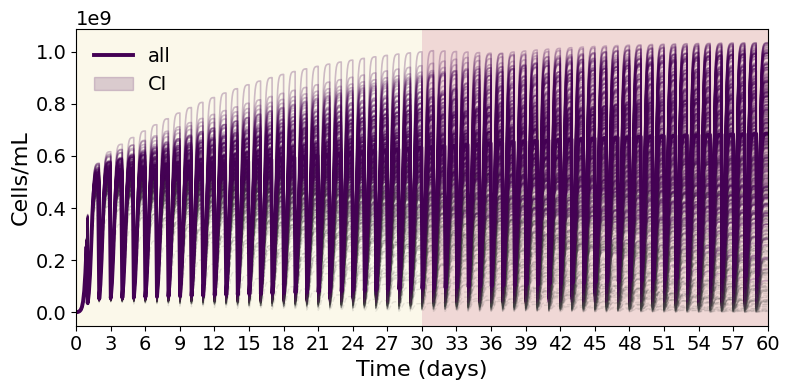

In [24]:
fig, ax = plot_trajectories_mean(
    runs,
    labelA=r"pMBA$_\emptyset$", labelB_base=family,
    alpha_bg=0.25, figsize=(8,4),
    show_ci=True, ci_quantiles=(0.16, 0.84),
    tick_every_hours=24*3,
    this_color='#440154', n_grid=600,
    to_days=True, day_hours=24.0
)

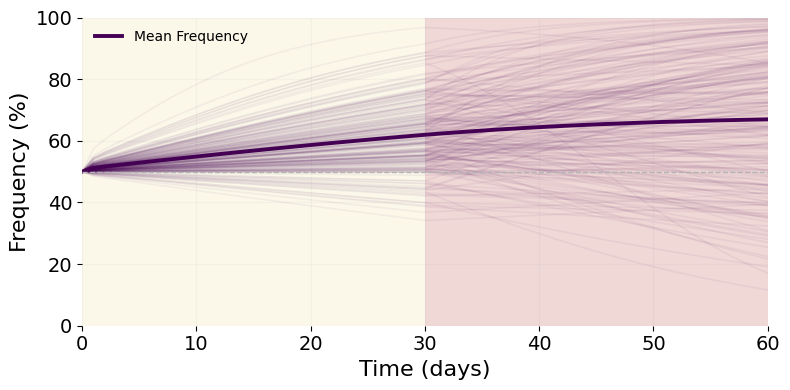

In [25]:
def _draw_env_band_simple(ax, segments, day_summaries, to_days=False, day_hours=24.0,
                          color_E="#B63E36", color_G="#EBDD99", alpha=0.20):
    """
    segments: list of tuples (t_abs_array, pops_array) per day
    day_summaries: DataFrame with column 'env' (values 'E' or 'G')
    """
    xscale = (1.0/day_hours) if to_days else 1.0
    for (t_abs, _), (_, row) in zip(segments, day_summaries.iterrows()):
        t0, t1 = float(t_abs[0])*xscale, float(t_abs[-1])*xscale
        c = color_E if str(row['env']).upper().startswith('E') else color_G
        ax.axvspan(t0, t1, color=c, alpha=alpha, lw=0)


def plot_replicates_daily_freq(
    res_list,
    *,
    which='B',                # 'A' or 'B'
    to_days=True, day_hours=24.0,
    percent=True,
    alpha_bg=0.05, show_mean=True, show_ci=True, ci_quantiles=(0.16, 0.84),
    this_color='#440154',
    figsize=(8, 4), legend_loc='upper left',
    pathFIGURES='',
    title=''
):
    """
    Uses `res['day_summaries']` to plot end-of-day frequencies for each replicate,
    prepending day 0 start. Highlights mean (and optional CI).
    """
    fig, ax = plt.subplots(figsize=figsize)
    xscale = (1.0/day_hours) if to_days else 1.0

    x_list, f_list = [], []

    res0 = res_list[0] if len(res_list) else None

    for res in res_list:
        # x: day 0 (0) + each day end time
        x_points = [0.0]
        for (t_abs, _), _row in zip(res['segments'], res['day_summaries'].iterrows()):
            x_points.append(float(t_abs[-1]) * xscale)

        df = res['day_summaries']
        if which.upper() == 'A':
            day0 = float(df.iloc[0]['fA_start'])
            f_end = df['fA_end'].to_numpy(float)
        else:
            day0 = float(df.iloc[0]['fB_start'])
            f_end = df['fB_end'].to_numpy(float)

        f = np.concatenate([[day0], f_end])
        if percent:
            f = 100.0 * f

        # faded individual
        ax.plot(x_points, f, color=this_color, lw=1.2, alpha=alpha_bg)

        x_list.append(np.asarray(x_points, float))
        f_list.append(np.asarray(f, float))

    # mean & CI on a common grid
    if f_list:
        same_grid = all(len(x) == len(x_list[0]) and np.allclose(x, x_list[0]) for x in x_list)
        if same_grid:
            x_grid = x_list[0]
            F = np.vstack(f_list)
        else:
            x_grid = np.unique(np.concatenate(x_list))
            F = np.vstack([np.interp(x_grid, x, y) for x, y in zip(x_list, f_list)])

        if show_mean:
            f_mean = F.mean(axis=0)
            ax.plot(x_grid, f_mean, color=this_color, lw=2.8, label=f"Mean Frequency")

        if show_ci and F.shape[0] >= 3:
            q_lo = np.quantile(F, ci_quantiles[0], axis=0)
            q_hi = np.quantile(F, ci_quantiles[1], axis=0)
            ax.fill_between(x_grid, q_lo, q_hi, color=this_color, alpha=0.18, label="CI")

        ax.set_xlim(x_grid[0], x_grid[-1])

    # environment band behind
    if res0 is not None:
        _draw_env_band_simple(ax, res0['segments'], res0['day_summaries'], to_days=to_days, day_hours=day_hours)

    # cosmetics
    ax.set_xlabel("Time (days)" if to_days else "Time (hours)")
    ax.set_ylabel(("Frequency (%)" if percent else "Frequency"))
    ax.axhline(50 if percent else 0.5, color='0.7', lw=1, ls='--')
    if not to_days:
        ax.xaxis.set_major_locator(MultipleLocator(24))
    ax.set_ylim(0, 100 if percent else 1.0)
    ax.grid(True, alpha=0.1)


    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.legend(frameon=False, loc=legend_loc)
    plt.tight_layout()

    #if title != '':
    #    ax.set_title(title, fontsize=16)

    if pathFIGURES != '':
            filename = f"{pathFIGURES}/replicates_daily_freq_{title}.pdf"
            plt.savefig(filename, format='pdf')
            print("Exporting %s" % filename)
    plt.show()

    return fig, ax

# Plot daily endpoint frequencies for B (in days)
fig2, ax2 = plot_replicates_daily_freq(
    runs,
    which='B',
    to_days=True,
    percent=True,
    legend_loc='upper left',
    show_ci=False,
)

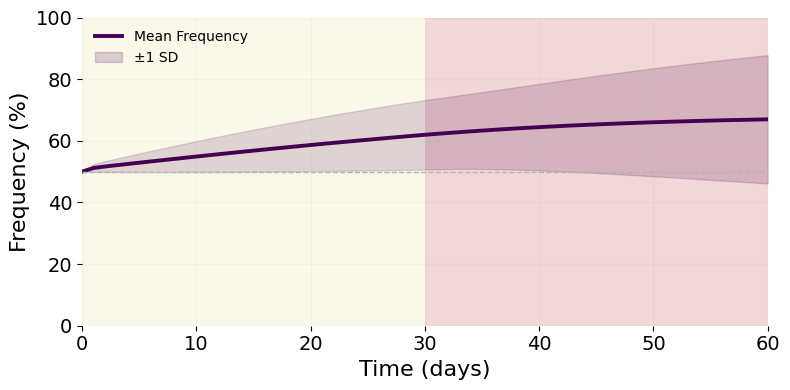

In [26]:

def plot_mean_daily_freq(
    res_list,
    *,
    which='B',                # 'A' or 'B'
    to_days=True, day_hours=24.0,
    percent=True,
    alpha_bg=0.25, show_mean=True, show_ci=True, ci_quantiles=(0.16, 0.84),
    this_color='#440154',
    figsize=(8, 4), legend_loc='upper left',
    pathFIGURES='',
    title=''
):
    """
    Uses `res['day_summaries']` to plot end-of-day frequencies for each replicate,
    prepending day 0 start. Highlights mean (and optional CI).
    """
    fig, ax = plt.subplots(figsize=figsize)
    xscale = (1.0/day_hours) if to_days else 1.0

    x_list, f_list = [], []

    res0 = res_list[0] if len(res_list) else None

    for res in res_list:
        # x: day 0 (0) + each day end time
        x_points = [0.0]
        for (t_abs, _), _row in zip(res['segments'], res['day_summaries'].iterrows()):
            x_points.append(float(t_abs[-1]) * xscale)

        df = res['day_summaries']
        if which.upper() == 'A':
            day0 = float(df.iloc[0]['fA_start'])
            f_end = df['fA_end'].to_numpy(float)
        else:
            day0 = float(df.iloc[0]['fB_start'])
            f_end = df['fB_end'].to_numpy(float)

        f = np.concatenate([[day0], f_end])
        if percent:
            f = 100.0 * f

        # faded individual
        #ax.plot(x_points, f, color=this_color, lw=1.2, alpha=alpha_bg)

        x_list.append(np.asarray(x_points, float))
        f_list.append(np.asarray(f, float))

    # mean & CI on a common grid
    if f_list:
        same_grid = all(len(x) == len(x_list[0]) and np.allclose(x, x_list[0]) for x in x_list)
        if same_grid:
            x_grid = x_list[0]
            F = np.vstack(f_list)
        else:
            x_grid = np.unique(np.concatenate(x_list))
            F = np.vstack([np.interp(x_grid, x, y) for x, y in zip(x_list, f_list)])

        if show_mean:
            f_mean = F.mean(axis=0)
            ax.plot(x_grid, f_mean, color=this_color, lw=2.8, label=f"Mean Frequency")

        if show_ci and F.shape[0] >= 2:
            f_mean = F.mean(axis=0)
            f_se   = F.std(axis=0, ddof=1) #/ np.sqrt(F.shape[0])  # standard error of the mean
            ax.fill_between(x_grid, f_mean - f_se, f_mean + f_se,
                            color=this_color, alpha=0.18, label="±1 SD")


        ax.set_xlim(x_grid[0], x_grid[-1])

    # environment band behind
    if res0 is not None:
        _draw_env_band_simple(ax, res0['segments'], res0['day_summaries'], to_days=to_days, day_hours=day_hours)

    # cosmetics
    ax.set_xlabel("Time (days)" if to_days else "Time (hours)")
    ax.set_ylabel(("Frequency (%)" if percent else "Frequency"))
    ax.axhline(50 if percent else 0.5, color='0.7', lw=1, ls='--')
    if not to_days:
        ax.xaxis.set_major_locator(MultipleLocator(24))
    ax.set_ylim(0, 100 if percent else 1.0)
    ax.grid(True, alpha=0.1)
    ax.legend(frameon=False, loc=legend_loc)

    # remove frame
    for spine in ax.spines.values():
        spine.set_visible(False)


    plt.tight_layout()


    if pathFIGURES != '':
            filename = f"{pathFIGURES}/mean_daily_freq_{title}.pdf"
            plt.savefig(filename, format='pdf')
            print("Exporting %s" % filename)
    plt.show()
    return fig, ax

# Plot daily endpoint frequencies for B (in days)
fig2, ax2 = plot_mean_daily_freq(
    runs,
    which='B',
    to_days=True,
    percent=True,
    legend_loc='upper left'
)

In [27]:
print(type(runs))
print(len(runs))
if len(runs) > 0:
    print(runs[0].keys())


<class 'list'>
221
dict_keys(['pair_idx', 'time', 'pops', 'segments', 'day_summaries'])


In [28]:
if len(runs):
    res_list_all = []
    for r in runs:
        res_list_all.append({
            'pair_idx': r['pair_idx'],
            'time': r['time'],
            'pops': r['pops'],
            'segments': r.get('segments', []),
            'day_summaries': r.get('day_summaries', None),
        })


Exporting /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/figures/replicates_daily_freq_all_sim.png


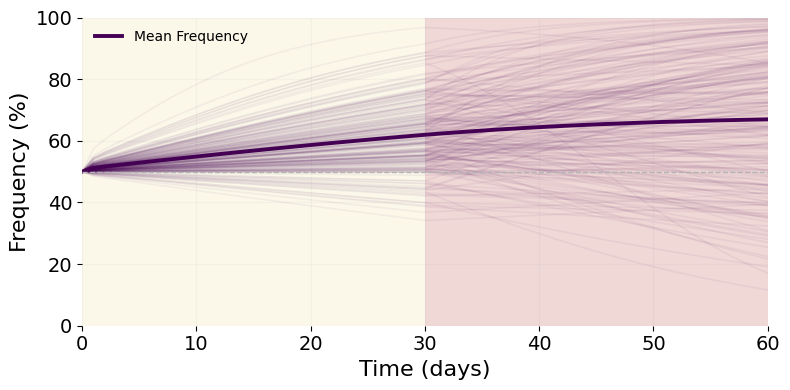

In [29]:


def plot_freq_time_density(
    res_list,
    *,
    which='B',                  # 'A' or 'B'
    to_days=True, day_hours=24.0,
    percent=True,
    n_time=200,                 # time grid resolution
    bins_freq=20,               # vertical bins for density
    cmap='heat',
    alpha_env=0.20,
    show_mean=True,
    show_ci=True, ci_quantiles=(0.16, 0.84),
    mean_color='#ffffff',
    figsize=(8.75,4),
    legend_loc='upper left',
    pathFIGURES='',
    title=''
):
    """
    Build a time×frequency density (2D histogram) across replicates and plot as a heatmap.
    Overlays mean (and optional CI) trajectory. Uses end-of-day points (including day 0).
    """
    if not res_list:
        fig, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, "No results", ha='center', va='center'); return fig, ax

    xscale = (1.0/day_hours) if to_days else 1.0

    # 1) Collect end-of-day (including day 0) trajectories from all replicates
    x_list, f_list = [], []
    for res in res_list:
        # time at day ends (prepend 0)
        x_points = [0.0]
        for (t_abs, _), _row in zip(res['segments'], res['day_summaries'].iterrows()):
            x_points.append(float(t_abs[-1]) * xscale)

        df = res['day_summaries']
        if which.upper() == 'A':
            day0 = float(df.iloc[0]['fA_start'])
            fend = df['fA_end'].to_numpy(float)
        else:
            day0 = float(df.iloc[0]['fB_start'])
            fend = df['fB_end'].to_numpy(float)

        f = np.concatenate([[day0], fend])
        if percent: f = 100.0 * f

        x_list.append(np.asarray(x_points, float))
        f_list.append(np.asarray(f, float))

    # 2) Common time grid and interpolation
    #    (Use union of time points so we never invent days)
    x_all = np.unique(np.concatenate(x_list))
    x_grid = np.linspace(x_all.min(), x_all.max(), n_time)
    F = np.vstack([np.interp(x_grid, x, y) for x, y in zip(x_list, f_list)])  # shape: (R, T)

    # 3) Build density per time column (histogram across replicates)
    f_min, f_max = (0.0, 100.0) if percent else (0.0, 1.0)
    edges = np.linspace(f_min, f_max, bins_freq + 1)
    centers = 0.5*(edges[:-1] + edges[1:])
    H = np.zeros((bins_freq, len(x_grid)), dtype=float)
    for j in range(len(x_grid)):
        col = F[:, j]
        hist, _ = np.histogram(col, bins=edges)
        H[:, j] = hist

    # normalize density per time (column) to max=1 for nice contrast (optional)
    with np.errstate(divide='ignore', invalid='ignore'):
        H = H / np.maximum(H.max(axis=0, keepdims=True), 1e-12)

    # 4) Plot heatmap
    fig, ax = plt.subplots(figsize=figsize)
    extent = [x_grid[0], x_grid[-1], f_min, f_max]
    #im = ax.imshow(
    #    H[::-1, :],             # flip so low freq at bottom
    #    aspect='auto',
    #    extent=extent,
    #    cmap=cmap,
    #    interpolation='nearest',
    #    vmin=0, vmax=1
    #)

    R = F.shape[0]
    H = H / max(R, 1)             # fraction of replicates per bin
    im = ax.imshow(
        H, origin='lower', aspect='auto', extent=extent, cmap=cmap,
        interpolation='nearest', vmin=0, vmax=H.max()
    )

    # 5) Overlay mean (and CI) trajectories
    if show_mean:
        f_mean = F.mean(axis=0)
        ax.plot(x_grid, f_mean, '--',color=mean_color, lw=2.2, label=f"Mean Frequency")


    # 6) Environment band (days) behind the plot if you have one replicate to copy
    try:
        res0 = res_list[0]
        # simple manual drawer that respects days vs hours
        for (t_abs, _), (_, row) in zip(res0['segments'], res0['day_summaries'].iterrows()):
            t0 = float(t_abs[0]) * xscale
            t1 = float(t_abs[-1]) * xscale
            env = str(row.get('env','G')).upper()
            col = "#B63E36" if env.startswith('E') else "#EBDD99"
            ax.axvspan(t0, t1, color=col, alpha=alpha_env, lw=0, zorder=-1)
    except Exception:
        pass

    # 7) Cosmetics
    ax.set_xlabel("Time (days)" if to_days else "Time (hours)")
    ax.set_ylabel("Frequency (%)" if percent else "Frequency")
    ax.set_ylim(f_min, f_max)
    if not to_days:
        ax.xaxis.set_major_locator(MultipleLocator(24))
    ax.grid(True, alpha=0.1)
    if show_mean or show_ci:
        ax.legend(frameon=False, loc=legend_loc, labelcolor="#FFFFFF")

    cbar = plt.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("Relative density")

    plt.tight_layout()

    if pathFIGURES != '':
            filename = f"{pathFIGURES}/freq_time_density_{title}.pdf"
            plt.savefig(filename, format='pdf')
            print("Exporting %s" % filename)
    plt.show()
    return fig, ax


fig2, ax2 = plot_replicates_daily_freq(
            res_list_all,
            which='B', to_days=True, percent=True,
            show_ci=False,
            legend_loc='upper left',
            pathFIGURES=pathFIGURES,
            title=f"{family}_{sched_name}"
        )


___

In [30]:

def plot_freq_time_with_highlights(
    res_list,
    *,
    which='B',                  # 'A' or 'B'
    to_days=True, day_hours=24.0,
    percent=True,
    n_time=200,                 # time grid resolution
    bins_freq=20,               # vertical bins for density
    cmap='Purples',
    alpha_env=0.20,
    show_mean=True,
    show_ci=False, ci_quantiles=(0.16, 0.84),
    mean_color='#000000',
    figsize=(8.,4),
    legend_loc='upper left',
    # --- highlight options ---
    highlight_ids=None,         # list of ids (e.g. pair_idx) to overlay
    fade_ids=None,
    id_key='pair_idx',          # key in each res dict with that id
    highlight_colors=None,      # dict {id: color}; else auto-cycle
    label_map=None,             # dict {id: "label text"}; default str(id)
    right_pad_frac=0.1,        # pad xlim to write labels
    alpha_bg_lines=0.8,          # (optional) fade all non-highlight lines (0 disables),
    pathFIGURES='',
    title=''
):
    """
    Time×frequency density (2D histogram) across replicates, with optional
    highlighted end-of-day trajectories overlaid and labeled at the right.
    """
    if not res_list:
        fig, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, "No results", ha='center', va='center')
        return fig, ax

    xscale = (1.0/day_hours) if to_days else 1.0
    highlight_ids = set(highlight_ids or [])
    fade_ids = set(fade_ids or [])

    fig, ax = plt.subplots(figsize=figsize)

    # 1) Collect end-of-day trajectories from all replicates
    x_list, f_list, ids = [], [], []
    for res in res_list:
        # time at day ends (prepend 0)
        x_points = [0.0]
        for (t_abs, _), _row in zip(res['segments'], res['day_summaries'].iterrows()):
            x_points.append(float(t_abs[-1]) * xscale)

        df = res['day_summaries']
        if which.upper() == 'A':
            day0 = float(df.iloc[0]['fA_start'])
            fend = df['fA_end'].to_numpy(float)
        else:
            day0 = float(df.iloc[0]['fB_start'])
            fend = df['fB_end'].to_numpy(float)

        f = np.concatenate([[day0], fend])
        if percent:
            f = 100.0 * f

        # faded individual
        if res.get(id_key, None) in fade_ids:
            ax.plot(x_points, f, color="#999999", lw=1.0, alpha=alpha_bg_lines)

        x_list.append(np.asarray(x_points, float))
        f_list.append(np.asarray(f, float))
        ids.append(res.get(id_key, None))

    # 2) Common time grid and interpolation
    x_all = np.unique(np.concatenate(x_list))
    x_grid = np.linspace(x_all.min(), x_all.max(), n_time)
    F = np.vstack([np.interp(x_grid, x, y) for x, y in zip(x_list, f_list)])  # shape: (R, T)

    # 3) Build density per time column
    f_min, f_max = (0.0, 100.0) if percent else (0.0, 1.0)
    edges = np.linspace(f_min, f_max, bins_freq + 1)
    centers = 0.5*(edges[:-1] + edges[1:])
    H = np.zeros((bins_freq, len(x_grid)), dtype=float)
    for j in range(len(x_grid)):
        col = F[:, j]
        hist, _ = np.histogram(col, bins=edges)
        H[:, j] = hist

    # normalize each column to max=1 (nice contrast)
    with np.errstate(divide='ignore', invalid='ignore'):
        H = H / np.maximum(H.max(axis=0, keepdims=True), 1e-12)

    extent = [x_grid[0], x_grid[-1], f_min, f_max]


    # 5) Overlay mean (and optional CI)
    if show_mean:
        f_mean = F.mean(axis=0)
        ax.plot(x_grid, f_mean, '--', color=mean_color, lw=2.2, label=f"Mean Frequency")
    if show_ci and F.shape[0] >= 3:
        q_lo = np.quantile(F, ci_quantiles[0], axis=0)
        q_hi = np.quantile(F, ci_quantiles[1], axis=0)
        ax.fill_between(x_grid, q_lo, q_hi, color=mean_color, alpha=0.18, label="CI")

    # 6) Environment band (days)
    try:
        res0 = res_list[0]
        for (t_abs, _), (_, row) in zip(res0['segments'], res0['day_summaries'].iterrows()):
            t0 = float(t_abs[0]) * xscale
            t1 = float(t_abs[-1]) * xscale
            env = str(row.get('env','G')).upper()
            col = "#B63E36" if env.startswith('E') else "#EBDD99"
            ax.axvspan(t0, t1, color=col, alpha=alpha_env, lw=0, zorder=-1)
    except Exception:
        pass

    # 8) Highlight selected ids, add right-side labels
    default_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['w'])
    highlight_colors = highlight_colors or {}
    label_map = label_map or {}
    x_min, x_max = x_grid[0], x_grid[-1]
    pad = right_pad_frac * (x_max - x_min if x_max > x_min else 1.0)
    ax.set_xlim(x_min, x_max + pad)

    handles, labels = [], []

    for rid, x, f in zip(ids, x_list, f_list):
        if rid in highlight_ids:
            col = highlight_colors.get(rid, default_cycle[len(highlight_colors) % len(default_cycle)])
            highlight_colors.setdefault(rid, col)
            ax.plot(x, f, color=col, lw=2.6, alpha=1.0, zorder=3)
            # right-edge label
            txt = label_map.get(rid, str(rid))
            ax.text(x_max + 0.02*pad, f[-1], txt, color=col, fontsize=10, ha='left', va='center', clip_on=False)
            # legend entry
            h, = ax.plot([], [], color=col, lw=2.6)
            handles.append(h); labels.append(txt)

    # 9) Cosmetics
    ax.set_xlabel("Time (days)" if to_days else "Time (hours)")
    ax.set_ylabel("Frequency (%)" if percent else "Frequency")
    ax.set_ylim(f_min, f_max)

    for spine in ax.spines.values():
        spine.set_visible(False)

    if not to_days:
        ax.xaxis.set_major_locator(MultipleLocator(24))
    ax.grid(True, alpha=0.1)

    #if (show_mean or show_ci) or handles:
    #    ax.legend(handles, labels, frameon=False, loc=legend_loc)


    plt.tight_layout()

    if title != '':
        ax.set_title(title)


    if pathFIGURES != '':
            filename = f"{pathFIGURES}/freq_time_with_highlights_{title}.pdf"
            plt.savefig(filename, format='pdf')
            print("Exporting %s" % filename)
    plt.show()
    return fig, ax


Exporting /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/figures/freq_time_with_highlights_all_sim.png


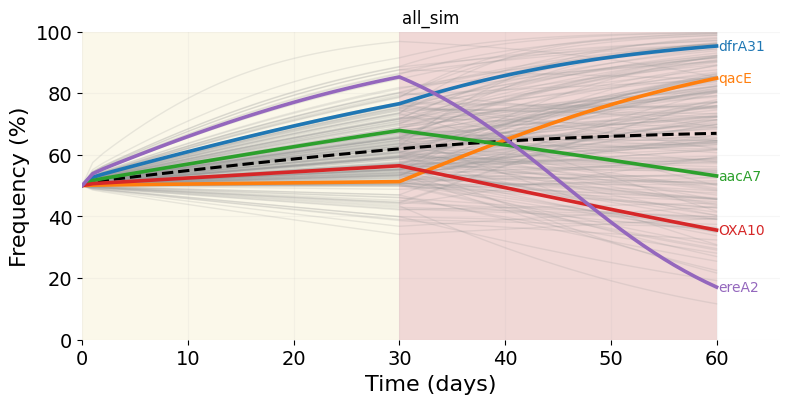

In [31]:
mask = df_family['label'].isin(labels_of_interest)
subset = df_family.loc[mask]
to_highlight = subset['pair_idx'].dropna().tolist()
to_fade = df_family['pair_idx'].dropna().tolist()
label_map = dict(zip(subset['pair_idx'], subset['label']))
highlight_colors = {}

fig5, ax5 = plot_freq_time_with_highlights(
            res_list_all, which='B', to_days=True, percent=True,
            highlight_ids=to_highlight, fade_ids=to_fade, id_key='pair_idx',
            label_map=label_map, highlight_colors=highlight_colors,
            alpha_bg_lines=0.2, legend_loc='upper left',
            pathFIGURES=pathFIGURES, title=f"{family}_{sched_name}"
)


Exporting /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness-main/figures/freq_time_density_with_highlights_all_sim.png


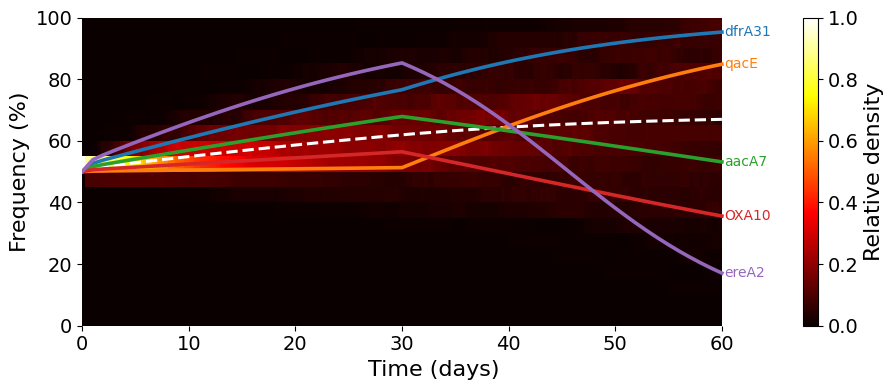

In [32]:

def plot_freq_time_density_with_highlights(
    res_list,
    *,
    which='B',                  # 'A' or 'B'
    to_days=True, day_hours=24.0,
    percent=True,
    n_time=200,                 # time grid resolution
    bins_freq=20,               # vertical bins for density
    cmap='hot',
    alpha_env=0.20,
    show_mean=True,
    show_ci=False, ci_quantiles=(0.16, 0.84),
    mean_color='#ffffff',
    figsize=(9.5,4),
    legend_loc='upper left',
    # --- highlight options ---
    highlight_ids=None,         # list of ids (e.g. pair_idx) to overlay
    id_key='pair_idx',          # key in each res dict with that id
    highlight_colors=None,      # dict {id: color}; else auto-cycle
    label_map=None,             # dict {id: "label text"}; default str(id)
    right_pad_frac=0.1,        # pad xlim to write labels
    alpha_bg_lines=0.0,          # (optional) fade all non-highlight lines (0 disables),
    pathFIGURES='',
    title=''
):
    """
    Time×frequency density (2D histogram) across replicates, with optional
    highlighted end-of-day trajectories overlaid and labeled at the right.
    """
    if not res_list:
        fig, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, "No results", ha='center', va='center')
        return fig, ax

    xscale = (1.0/day_hours) if to_days else 1.0
    highlight_ids = set(highlight_ids or [])

    # 1) Collect end-of-day trajectories from all replicates
    x_list, f_list, ids = [], [], []
    for res in res_list:
        # time at day ends (prepend 0)
        x_points = [0.0]
        for (t_abs, _), _row in zip(res['segments'], res['day_summaries'].iterrows()):
            x_points.append(float(t_abs[-1]) * xscale)

        df = res['day_summaries']
        if which.upper() == 'A':
            day0 = float(df.iloc[0]['fA_start'])
            fend = df['fA_end'].to_numpy(float)
        else:
            day0 = float(df.iloc[0]['fB_start'])
            fend = df['fB_end'].to_numpy(float)

        f = np.concatenate([[day0], fend])
        if percent:
            f = 100.0 * f

        x_list.append(np.asarray(x_points, float))
        f_list.append(np.asarray(f, float))
        ids.append(res.get(id_key, None))

    # 2) Common time grid and interpolation
    x_all = np.unique(np.concatenate(x_list))
    x_grid = np.linspace(x_all.min(), x_all.max(), n_time)
    F = np.vstack([np.interp(x_grid, x, y) for x, y in zip(x_list, f_list)])  # shape: (R, T)

    # 3) Build density per time column
    f_min, f_max = (0.0, 100.0) if percent else (0.0, 1.0)
    edges = np.linspace(f_min, f_max, bins_freq + 1)
    centers = 0.5*(edges[:-1] + edges[1:])
    H = np.zeros((bins_freq, len(x_grid)), dtype=float)
    for j in range(len(x_grid)):
        col = F[:, j]
        hist, _ = np.histogram(col, bins=edges)
        H[:, j] = hist

    # normalize each column to max=1 (nice contrast)
    #with np.errstate(divide='ignore', invalid='ignore'):
    #    H = H / np.maximum(H.max(axis=0, keepdims=True), 1e-12)
    #H = H / H.max()
    #print(H.max())


    # 4) Plot heatmap
    fig, ax = plt.subplots(figsize=figsize)
    extent = [x_grid[0], x_grid[-1], f_min, f_max]

    R = F.shape[0]
    H = H / max(R, 1)             # fraction of replicates per bin
    im = ax.imshow(
        H, origin='lower', aspect='auto', extent=extent, cmap=cmap,
        interpolation='nearest', vmin=0, vmax=H.max()
    )


    handles, labels = [], []

    # 5) Overlay mean (and optional CI)
    if show_mean:
        f_mean = F.mean(axis=0)
        h, = ax.plot(x_grid, f_mean, '--', color=mean_color, lw=2.2, label=f"Mean Frequency")
        handles.append(h); labels.append("Mean Frequency")
    if show_ci and F.shape[0] >= 3:
        q_lo = np.quantile(F, ci_quantiles[0], axis=0)
        q_hi = np.quantile(F, ci_quantiles[1], axis=0)
        ax.fill_between(x_grid, q_lo, q_hi, color=mean_color, alpha=0.18, label="CI")

    # 6) Environment band (days)
    try:
        res0 = res_list[0]
        for (t_abs, _), (_, row) in zip(res0['segments'], res0['day_summaries'].iterrows()):
            t0 = float(t_abs[0]) * xscale
            t1 = float(t_abs[-1]) * xscale
            env = str(row.get('env','G')).upper()
            col = "#B63E36" if env.startswith('E') else "#EBDD99"
            ax.axvspan(t0, t1, color=col, alpha=alpha_env, lw=0, zorder=-1)
    except Exception:
        pass

    # 7) Optional overlay of individual lines (non-highlight faded)
    #    (Useful to see discrete paths over the density)
    #if alpha_bg_lines > 0:
    #    for x, f, rid in zip(x_list, f_list, ids):
    #        if rid not in highlight_ids:
    #            ax.plot(x, f, color='0.6', lw=1.0, alpha=alpha_bg_lines, zorder=1)

    # 8) Highlight selected ids, add right-side labels
    default_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['w'])
    highlight_colors = highlight_colors or {}
    label_map = label_map or {}
    x_min, x_max = x_grid[0], x_grid[-1]
    pad = right_pad_frac * (x_max - x_min if x_max > x_min else 1.0)
    ax.set_xlim(x_min, x_max + pad)


    for rid, x, f in zip(ids, x_list, f_list):
        if rid in highlight_ids:
            col = highlight_colors.get(rid, default_cycle[len(highlight_colors) % len(default_cycle)])
            highlight_colors.setdefault(rid, col)
            ax.plot(x, f, color=col, lw=2.6, alpha=1.0, zorder=3)
            # right-edge label
            txt = label_map.get(rid, str(rid))
            ax.text(x_max + 0.04*pad, f[-1], txt, color=col, fontsize=10, ha='left', va='center', clip_on=False)
            # legend entry
            h, = ax.plot([], [], color=col, lw=2.6)
            handles.append(h); labels.append(txt)

    # 9) Cosmetics
    ax.set_xlabel("Time (days)" if to_days else "Time (hours)")
    ax.set_ylabel("Frequency (%)" if percent else "Frequency")
    ax.set_ylim(f_min, f_max)

    for spine in ax.spines.values():
        spine.set_visible(False)

    if not to_days:
        ax.xaxis.set_major_locator(MultipleLocator(24))
    ax.grid(True, alpha=0.)

    #if (show_mean or show_ci) or handles:
    #    ax.legend(handles, labels, frameon=False, loc=legend_loc, labelcolor="#FFFFFF")

    cbar = plt.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("Relative density")

    plt.tight_layout()


    if pathFIGURES != '':
            filename = f"{pathFIGURES}/freq_time_density_with_highlights_{title}.pdf"
            plt.savefig(filename, format='pdf')
            print("Exporting %s" % filename)
    plt.show()
    return fig, ax



fig, ax = plot_freq_time_density_with_highlights(
            res_list_all, which='B', to_days=True, percent=True,
            highlight_ids=to_highlight, id_key='pair_idx',
            label_map=label_map, highlight_colors=highlight_colors,
            alpha_bg_lines=0.5, legend_loc='upper left',
            pathFIGURES=pathFIGURES, title=f"{family}_{sched_name}"
        )